In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [274]:
class Sequential_modified(nn.Sequential):
    def __init__(self, width_list, seed):
        self.seed = seed
        torch.manual_seed(self.seed)
        self.width_list = width_list
        layer_sizes = list(zip(width_list[:-1],width_list[1:]))
        layer_list = []
        for size in layer_sizes[:-1]:
            layer_list.append(nn.Linear(*size))
            layer_list.append(nn.ReLU())
        layer_list.append(nn.Linear(*layer_sizes[-1]))
        super().__init__(*layer_list)

        
def generate_numbers_mul_to_1(num, range_):
    torch.manual_seed(random.randint(0,10000))
    rand_numbers = (range_[1]-range_[0]) * torch.rand(num) + range_[0]
    m = 1.0
    for i in range(num):
        m *= rand_numbers[i]
    rand_numbers = rand_numbers/(m**(1/num))
    return rand_numbers

def scale_net(net, factors):
    layers = filter(lambda layer:isinstance(layer, nn.Linear), net)
    for i, layer in enumerate(layers):
        layer.weight.data = factors[i] * layer.weight.data
        layer.bias.data = multiply_list_of_num(factors[:i+1]) * layer.bias.data
    return net

def diagonal_matrix_symmetry_1(net, range_):
    for i, layer in enumerate(net):
        if isinstance(layer, nn.ReLU):
            d = net[i-1].weight.data.shape[0]
            v = (range_[1]-range_[0])*torch.rand(d) + range_[0]
            diag_mat = torch.diag(v).to('cuda:0')
            diag_mat_inv = torch.diag(1/v).to('cuda:0')
            net[i-1].weight.data = torch.matmul(diag_mat, net[i-1].weight.data)
            net[i-1].bias.data = torch.matmul(diag_mat, net[i-1].bias.data)
            net[i+1].weight.data = torch.matmul(net[i+1].weight.data, diag_mat_inv)
    return net


def diagonal_matrix_symmetry_balanced_1(net, range_, symm_counter):
    torch.manual_seed(symm_counter//2)
    for i, layer in enumerate(net):
        if isinstance(layer, nn.ReLU):
            d = net[i-1].weight.data.shape[0]
            v = (range_[1]-range_[0])*torch.rand(d) + range_[0]
            if symm_counter%2 == 1:
                v = 1/v
            diag_mat = torch.diag(v).to('cuda:0')
            diag_mat_inv = torch.diag(1/v).to('cuda:0')
            net[i-1].weight.data = torch.matmul(diag_mat, net[i-1].weight.data)
            net[i-1].bias.data = torch.matmul(diag_mat, net[i-1].bias.data)
            net[i+1].weight.data = torch.matmul(net[i+1].weight.data, diag_mat_inv)
    return net


def diagonal_matrix_symmetry_balanced_2(net, scale, symm_counter):
    torch.manual_seed(symm_counter//2)
    for i, layer in enumerate(net):
        if isinstance(layer, nn.ReLU):
            d = net[i-1].weight.data.shape[0]
            v = (2*torch.rand(d) - 1)
            v = ((v>0)*v) * scaler + ((v<0)*v.abs()) / scaler
            if symm_counter%2 == 1:
                v = 1/v
            diag_mat = torch.diag(v).to('cuda:0')
            diag_mat_inv = torch.diag(1/v).to('cuda:0')
            net[i-1].weight.data = torch.matmul(diag_mat, net[i-1].weight.data)
            net[i-1].bias.data = torch.matmul(diag_mat, net[i-1].bias.data)
            net[i+1].weight.data = torch.matmul(net[i+1].weight.data, diag_mat_inv)
    return net


def diagonal_matrix_symmetry_balanced_3(net, scale, symm_counter):
    torch.manual_seed(symm_counter//2)
    for i, layer in enumerate(net):
        if isinstance(layer, nn.ReLU):
            d = net[i-1].weight.data.shape[0]
            v = (2*torch.rand(d) - 1)
            v = ((v>0)*v) * scaler + ((v<0)*(v.abs()+(1/scaler)))
            if symm_counter%2 == 1:
                v = 1/v
            diag_mat = torch.diag(v).to('cuda:0')
            diag_mat_inv = torch.diag(1/v).to('cuda:0')
            net[i-1].weight.data = torch.matmul(diag_mat, net[i-1].weight.data)
            net[i-1].bias.data = torch.matmul(diag_mat, net[i-1].bias.data)
            net[i+1].weight.data = torch.matmul(net[i+1].weight.data, diag_mat_inv)
    return net

def turn_grad_off(net, weights=True, bias=True):
    for idx, param in net.named_children():
        if isinstance(param, nn.Linear):
            if weights:
                param.weight.requires_grad = False
            if bias:
                param.bias.requires_grad = False
    return net

def diff(net1, net2):
    input_size = net1[0].weight.data.shape[1]
    random_input = torch.randn(10000,input_size)
    error = (net2(random_input)-net1(random_input)).abs().max()
    return error

def multiply_list_of_num(list_):
    multiplication = 1
    for num in list_:
        multiplication *= num
    return multiplication

def clone_net(old_net):
    new_layers = []
    for old_layer in old_net:
        if isinstance(old_layer, nn.Linear):
            new_layer = nn.Linear(*(old_layer.weight.shape[::-1]))
            new_layer.weight.data = torch.tensor(old_layer.weight.data.tolist().copy()).to('cuda:0')
            new_layer.bias.data = torch.tensor(old_layer.bias.data.tolist().copy()).to('cuda:0')
        if isinstance(old_layer, nn.ReLU):
            new_layer = nn.ReLU()
        new_layers.append(new_layer)
    new_net = nn.Sequential(*new_layers)
    return new_net


def copy_weights(src_net, dst_net):
    with torch.no_grad():
        for dst_params, src_params in zip(dst_net.parameters(), src_net.parameters()):
            dst_params.copy_(src_params)
            
def revert_condition(loss, iter_loss, threshold=0.1):
    if iter_loss:
        return iter_loss[-1][0] > 1 and (loss-iter_loss[-1][1])/iter_loss[-1][1] > threshold
    return False

In [231]:
class Sequential_modified(nn.Sequential):
    def __init__(self, width_list, seed):
        self.seed = seed
        torch.manual_seed(self.seed)
        self.width_list = width_list
        layer_sizes = list(zip(width_list[:-1],width_list[1:]))
        layer_list = []
        for size in layer_sizes[:-1]:
            layer_list.append(nn.Linear(*size))
            layer_list.append(nn.ReLU())
        layer_list.append(nn.Linear(*layer_sizes[-1]))
        super().__init__(*layer_list)

    def jump_to_symmetrical_point(self, symmetrical_point_generator, *args):
        symmetrical_point_generator(self, *args)

In [81]:
if ['a']:
    print('aaa')

aaa


In [ ]:
def train(module, data_loader, weight_symmetry_function, weight_symmetry_condition, revert_condition, ):

In [26]:
n.jump_to_symmetrical_point(scale_net_type2, [0.5,1.5])
print(n[0].weight.data)

tensor([[-0.0330, -0.0135, -0.1477,  0.0906, -0.2254],
        [-0.1148,  0.2524,  0.6113,  0.1534, -0.2210],
        [ 0.0638, -0.0745,  0.2715,  0.0762,  0.2606],
        [ 0.4113, -0.1761, -0.0150,  0.0975, -0.0028],
        [-0.0360, -0.3327, -0.3243, -0.3383, -0.3679],
        [-0.4489, -0.3651, -0.4347, -0.4521,  0.2113],
        [ 0.3626,  0.3995,  0.3185,  0.2003,  0.2604],
        [-0.3624,  0.5900, -0.0452,  0.5654,  0.2009],
        [ 0.5091,  0.5189, -0.1359, -0.1892,  0.0979],
        [-0.0234,  0.0862,  0.2796, -0.4307, -0.0253]], device='cuda:0')


In [422]:
lr_loss1 = []
lr_loss2 = []
num_points = 1001

for lr in np.linspace(0, 1, num_points):
    net1 = Sequential_modified(width_list, 100)
    net2 = Sequential_modified(width_list, net1.seed)
    
    net2 = scale_net(net2, factors)
    
    optim1 = torch.optim.SGD(net1.parameters(), lr=lr)
    optim2 = torch.optim.SGD(net2.parameters(), lr=lr)
    
    optim1.zero_grad()
    y1 = net1(x)
    loss1 = criterion1(y1,targets)
    loss1.backward()
    optim1.step()
    y1 = net1(x)
    loss1 = criterion1(y1,targets)
    lr_loss1.append((lr,loss1.item()))
    
    optim2.zero_grad()
    y2 = net2(x)
    loss2 = criterion2(y2,targets)
    loss2.backward()
    optim2.step()
    y2 = net2(x)
    loss2 = criterion2(y2,targets)
    lr_loss2.append((lr,loss2.item()))

0.7933530211448669

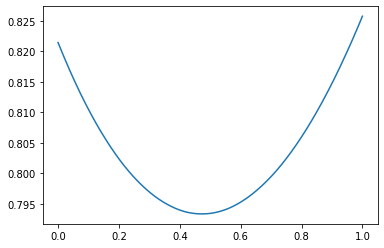

In [423]:
lr, loss1 = zip(*lr_loss1)
plt.plot(lr[0:num_points], loss1[0:num_points])
min(loss1)

0.750558078289032

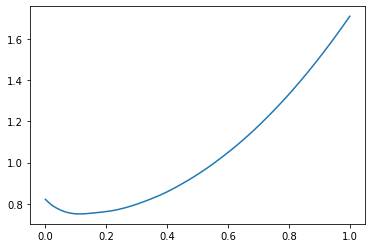

In [424]:
lr, loss2 = zip(*lr_loss2)
plt.plot(lr[0:num_points], loss2[0:num_points])
min(loss2)

In [419]:
factors

[0.1, 2.5, 4]

In [4]:
width_list=[5,10,10,10,10,1]
batch_size = 1000
x = torch.randn(batch_size,width_list[0])
labels_net = Sequential_modified(width_list, 123)
targets = labels_net(x)
targets = targets.detach()

criterion1 = torch.nn.MSELoss()

In [33]:
start_time = time.time()
iter_loss1 = []

num_iter1 = 200000
lr = 0.001
net1 = Sequential_modified(width_list, 300)

x = x.to('cuda:0')
targets = targets.to('cuda:0')
net1 = net1.to('cuda:0')

optim1 = torch.optim.SGD(net1.parameters(), lr=lr)
for iter_ in range(num_iter1):
    optim1.zero_grad()
    y1 = net1(x)
    loss1 = criterion1(y1,targets)
    iter_loss1.append((iter_,loss1.item()))
    loss1.backward()
    optim1.step()
loss1 = criterion1(y1,targets)
iter_loss1.append((iter_+1,loss1.item()))
elapsed_time = time.time() - start_time
print(elapsed_time)

579.4294760227203


In [113]:
start = 2000
stop = 300000
iter_, loss1 = zip(*iter_loss1)
plt.plot(iter_[start:stop], loss1[start:stop])
print(min(loss1))

iter_, loss2 = zip(*iter_loss2)
plt.plot(iter_[start:stop], loss2[start:stop])
print(min(loss2))

NameError: name 'iter_loss1' is not defined

In [240]:
def net_at_stationary_point(iter_loss, iter_interval=100, percentage=1):
    loss1, loss2 = iter_loss[-iter_interval][1], iter_loss[-1][1]
    return abs(loss1-loss2)/loss1*100 < percentage

In [277]:
start_time = time.time()
iter_loss2 = []

num_iter1 = 200000
lr = 0.001
net1 = Sequential_modified(width_list, 200)

x = x.to('cuda:0')
targets = targets.to('cuda:0')
net1 = net1.to('cuda:0')

old_net = Sequential_modified(width_list, 11234)
old_net = old_net.to('cuda:0')

optim1 = torch.optim.SGD(net1.parameters(), lr=lr)
symm_counter = 0
for iter_ in range(num_iter1):
    optim1.zero_grad()
    y1 = net1(x)
    loss2 = criterion1(y1,targets)
    if revert_condition(loss2, iter_loss2):
        print(f'[{iter_}] Bad location:  retrive to old net ..')
#         net1 = clone_net(old_net)
#         optim1 = torch.optim.SGD(net1.parameters(), lr=lr)
        copy_weights(old_net, net1)
        symm_counter += 1  ##### ???????????????????????????????????????????????????????
        continue
    iter_loss2.append((iter_,loss2.item()))
    loss2.backward()
    optim1.step()
    if (iter_+1)%100 == 0 and net_at_stationary_point(iter_loss2, iter_interval=100,percentage=0.1):
        print(f'[{iter_}] At stationary point:  calculating eqivelant net ..')
#         old_net = clone_net(net1)
        copy_weights(net1, old_net)
#         factors = generate_numbers_mul_to_1(len(width_list)-1,[0.7n = clone_net(net1),1.3])
#         net1 = scale_net(net1, factors)
        net1 = diagonal_matrix_symmetry_balanced_3(net1, [0.01,100], symm_counter)
        symm_counter += 1
loss2 = criterion1(y1,targets)
iter_loss2.append((iter_+1,loss2.item()))
elapsed_time = time.time() - start_time
print(elapsed_time)

[36399] At stationary point:  calculating eqivelant net ..
[47199] At stationary point:  calculating eqivelant net ..
[47299] At stationary point:  calculating eqivelant net ..
[56499] At stationary point:  calculating eqivelant net ..
[56599] At stationary point:  calculating eqivelant net ..
[64899] At stationary point:  calculating eqivelant net ..
[64999] At stationary point:  calculating eqivelant net ..
[65099] At stationary point:  calculating eqivelant net ..
[65199] At stationary point:  calculating eqivelant net ..
[65299] At stationary point:  calculating eqivelant net ..
[65399] At stationary point:  calculating eqivelant net ..
[65699] At stationary point:  calculating eqivelant net ..
[65799] At stationary point:  calculating eqivelant net ..
[65899] At stationary point:  calculating eqivelant net ..
[65999] At stationary point:  calculating eqivelant net ..
[70999] At stationary point:  calculating eqivelant net ..
[71099] At stationary point:  calculating eqivelant net 

[97599] At stationary point:  calculating eqivelant net ..
[97699] At stationary point:  calculating eqivelant net ..
[97799] At stationary point:  calculating eqivelant net ..
[97899] At stationary point:  calculating eqivelant net ..
[97999] At stationary point:  calculating eqivelant net ..
[98099] At stationary point:  calculating eqivelant net ..
[98199] At stationary point:  calculating eqivelant net ..
[98299] At stationary point:  calculating eqivelant net ..
[98399] At stationary point:  calculating eqivelant net ..
[98499] At stationary point:  calculating eqivelant net ..
[98599] At stationary point:  calculating eqivelant net ..
[98699] At stationary point:  calculating eqivelant net ..
[98799] At stationary point:  calculating eqivelant net ..
[98899] At stationary point:  calculating eqivelant net ..
[98999] At stationary point:  calculating eqivelant net ..
[99099] At stationary point:  calculating eqivelant net ..
[102399] At stationary point:  calculating eqivelant net

[120599] At stationary point:  calculating eqivelant net ..
[120699] At stationary point:  calculating eqivelant net ..
[120799] At stationary point:  calculating eqivelant net ..
[120804] Bad location:  retrive to old net ..
[120899] At stationary point:  calculating eqivelant net ..
[120999] At stationary point:  calculating eqivelant net ..
[121099] At stationary point:  calculating eqivelant net ..
[121199] At stationary point:  calculating eqivelant net ..
[121299] At stationary point:  calculating eqivelant net ..
[121399] At stationary point:  calculating eqivelant net ..
[121499] At stationary point:  calculating eqivelant net ..
[121599] At stationary point:  calculating eqivelant net ..
[121699] At stationary point:  calculating eqivelant net ..
[121799] At stationary point:  calculating eqivelant net ..
[121899] At stationary point:  calculating eqivelant net ..
[121999] At stationary point:  calculating eqivelant net ..
[122099] At stationary point:  calculating eqivelant n

[136299] At stationary point:  calculating eqivelant net ..
[136399] At stationary point:  calculating eqivelant net ..
[136499] At stationary point:  calculating eqivelant net ..
[136599] At stationary point:  calculating eqivelant net ..
[136699] At stationary point:  calculating eqivelant net ..
[136799] At stationary point:  calculating eqivelant net ..
[136899] At stationary point:  calculating eqivelant net ..
[136999] At stationary point:  calculating eqivelant net ..
[137099] At stationary point:  calculating eqivelant net ..
[137199] At stationary point:  calculating eqivelant net ..
[137299] At stationary point:  calculating eqivelant net ..
[137399] At stationary point:  calculating eqivelant net ..
[137499] At stationary point:  calculating eqivelant net ..
[137599] At stationary point:  calculating eqivelant net ..
[137699] At stationary point:  calculating eqivelant net ..
[137799] At stationary point:  calculating eqivelant net ..
[137899] At stationary point:  calculati

[152599] At stationary point:  calculating eqivelant net ..
[152699] At stationary point:  calculating eqivelant net ..
[152799] At stationary point:  calculating eqivelant net ..
[152899] At stationary point:  calculating eqivelant net ..
[152999] At stationary point:  calculating eqivelant net ..
[153099] At stationary point:  calculating eqivelant net ..
[153199] At stationary point:  calculating eqivelant net ..
[153299] At stationary point:  calculating eqivelant net ..
[153399] At stationary point:  calculating eqivelant net ..
[153499] At stationary point:  calculating eqivelant net ..
[153599] At stationary point:  calculating eqivelant net ..
[154199] At stationary point:  calculating eqivelant net ..
[154299] At stationary point:  calculating eqivelant net ..
[154399] At stationary point:  calculating eqivelant net ..
[154499] At stationary point:  calculating eqivelant net ..
[154599] At stationary point:  calculating eqivelant net ..
[154699] At stationary point:  calculati

[168599] At stationary point:  calculating eqivelant net ..
[168699] At stationary point:  calculating eqivelant net ..
[168799] At stationary point:  calculating eqivelant net ..
[168899] At stationary point:  calculating eqivelant net ..
[168999] At stationary point:  calculating eqivelant net ..
[169099] At stationary point:  calculating eqivelant net ..
[169199] At stationary point:  calculating eqivelant net ..
[169299] At stationary point:  calculating eqivelant net ..
[169399] At stationary point:  calculating eqivelant net ..
[169499] At stationary point:  calculating eqivelant net ..
[169599] At stationary point:  calculating eqivelant net ..
[169699] At stationary point:  calculating eqivelant net ..
[169799] At stationary point:  calculating eqivelant net ..
[169899] At stationary point:  calculating eqivelant net ..
[169999] At stationary point:  calculating eqivelant net ..
[170099] At stationary point:  calculating eqivelant net ..
[170199] At stationary point:  calculati

[182299] At stationary point:  calculating eqivelant net ..
[182899] At stationary point:  calculating eqivelant net ..
[182999] At stationary point:  calculating eqivelant net ..
[183099] At stationary point:  calculating eqivelant net ..
[183199] At stationary point:  calculating eqivelant net ..
[183299] At stationary point:  calculating eqivelant net ..
[183399] At stationary point:  calculating eqivelant net ..
[183499] At stationary point:  calculating eqivelant net ..
[183599] At stationary point:  calculating eqivelant net ..
[183699] At stationary point:  calculating eqivelant net ..
[183799] At stationary point:  calculating eqivelant net ..
[183899] At stationary point:  calculating eqivelant net ..
[183999] At stationary point:  calculating eqivelant net ..
[184099] At stationary point:  calculating eqivelant net ..
[184199] At stationary point:  calculating eqivelant net ..
[184299] At stationary point:  calculating eqivelant net ..
[184399] At stationary point:  calculati

5.640387826133519e-06

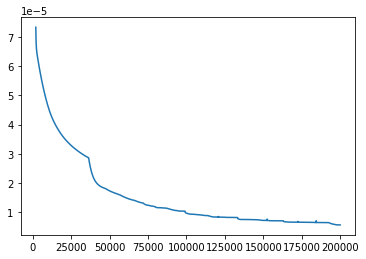

In [279]:
start = 2000
iter_, loss2 = zip(*iter_loss2)
plt.plot(iter_[start:], loss2[start:])
min(loss2)

9.591623211235856e-07

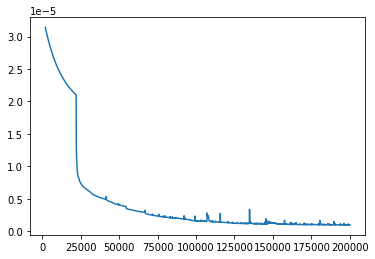

In [235]:
start = 2000
iter_, loss2 = zip(*iter_loss2)
plt.plot(iter_[start:], loss2[start:])
min(loss2)

1.365399953101587e-06

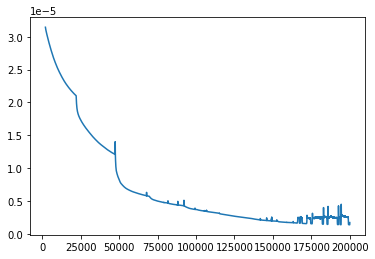

In [114]:
start = 2000
iter_, loss2 = zip(*iter_loss2)
plt.plot(iter_[start:], loss2[start:])
min(loss2)

In [121]:
for i, l in enumerate(net1):
    if isinstance(l, nn.Linear):
        w = l.weight.data.cpu().flatten()
        print(i)
#         plt.figure()
#         plt.hist(w)
        print(f'max = {max(abs(w))} \nmin = {min(abs(w))}')
        print('\n\n')

0
max = 38.04113006591797 
min = 0.08715080469846725



2
max = 1.5745043754577637 
min = 0.0021841109264642



4
max = 3.157644748687744 
min = 0.0012977380538359284



6
max = 4.850064277648926 
min = 0.00048151344526559114



8
max = 0.017153698951005936 
min = 7.804937195032835e-05





In [280]:
for i, l in enumerate(net1):
    if isinstance(l, nn.Linear):
        w = l.weight.data.cpu().flatten()
        print(i)
#         plt.figure()
#         plt.hist(w)
        print(f'max = {max(abs(w))} \nmin = {min(abs(w))}')
        print('\n\n')

0
max = 3.6676723957061768 
min = 0.0009450032957829535



2
max = 2.4450809955596924 
min = 5.157007194611651e-07



4
max = 7988.0712890625 
min = 0.004598158877342939



6
max = 5.295494079589844 
min = 0.00012949939991813153



8
max = 2.0893146991729736 
min = 0.0019502161303535104





In [25]:
a0 = net1[0].weight.data.cpu()

In [27]:
a0 = a0.flatten().tolist()

(array([ 1.,  1.,  0.,  1.,  0.,  1.,  3., 40.,  1.,  2.]),
 array([-194.44639587, -167.46435318, -140.48231049, -113.50026779,
         -86.5182251 ,  -59.5361824 ,  -32.55413971,   -5.57209702,
          21.40994568,   48.39198837,   75.37403107]),
 <BarContainer object of 10 artists>)

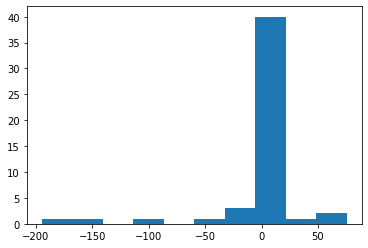

In [28]:
plt.hist(a0)

In [40]:
for l in net1:
    if isinstance(l,nn.Linear):
        print(l.weight.data)
        print(l.bias.data)
        print()

tensor([[-5.9637e-03, -2.3248e-02,  3.1903e-02,  1.0911e-01, -4.6071e-03],
        [-1.4190e+00, -1.5413e+00, -7.9573e+00,  5.4617e+00, -5.1666e+00],
        [-5.9956e-01, -7.8389e-01,  2.4906e-01, -5.6519e-01,  2.2806e-01],
        [-1.0562e-04,  4.4877e-05, -1.1258e-04,  2.6549e-04,  4.1885e-04],
        [-1.0300e-02,  4.2106e-03,  1.0836e-02,  6.0312e-03,  4.5060e-03],
        [-2.1892e+00, -1.5306e+00,  1.4012e+00, -1.2771e+00,  2.1137e+00],
        [-2.3750e-04,  7.9866e-04,  8.9205e-04,  1.0761e-03, -3.7757e-04],
        [-3.0206e-02,  6.1366e-03,  1.8046e-02, -1.5663e-04, -8.8449e-03],
        [-3.8713e+00, -6.3987e+00, -2.1507e+00,  5.2316e+00, -2.8268e+00],
        [ 5.8043e-01, -5.2455e-01, -3.0501e-01,  3.8463e-01,  4.4293e-01]],
       device='cuda:0')
tensor([ 1.6794e-01,  2.9716e+00, -7.2916e-01,  4.9050e-04, -5.6470e-03,
         2.5688e+00,  3.1474e-03,  6.1435e-03, -2.3564e+00,  3.6144e-01],
       device='cuda:0')

tensor([[-1.9932e-01, -5.2386e-04,  6.3514e-02, -5.88

In [12]:
0.00013252634380478412

0.00013252634380478412

In [4]:
x = torch.randn(100,5)
x = x.to('cuda:0')

In [ ]:
class Random_data_loa

In [ ]:
torch.utils.data.DataLoader()

In [75]:
class Random_data():
    def __init__(self, Architecture, batch_size, num_iterations):
        self.x = torch.randn(batch_size, Architecture[0])
        labels_net = Sequential_modified(width_list, 123)
        self.targets = labels_net(x).detach()
        self.num_iterations = num_iterations
    def __getitem__(self, idx):
        return self.x, self.targets
    def __len__(self):
        return self.num_iterations

In [76]:
from torch.utils.data import DataLoader

In [78]:
data = Random_data(width_list, 3, 10)
data_loader = DataLoader(data)
print(len(data))
for x, target in data_loader:
    print(x)

10
tensor([[[ 0.7507,  0.1941, -0.5153,  0.3557,  0.4701],
         [ 1.1138, -0.7832, -1.4160, -0.7005, -0.2032],
         [ 1.2721,  1.0418, -0.3025, -0.6228,  1.7089]]])
tensor([[[ 0.7507,  0.1941, -0.5153,  0.3557,  0.4701],
         [ 1.1138, -0.7832, -1.4160, -0.7005, -0.2032],
         [ 1.2721,  1.0418, -0.3025, -0.6228,  1.7089]]])
tensor([[[ 0.7507,  0.1941, -0.5153,  0.3557,  0.4701],
         [ 1.1138, -0.7832, -1.4160, -0.7005, -0.2032],
         [ 1.2721,  1.0418, -0.3025, -0.6228,  1.7089]]])
tensor([[[ 0.7507,  0.1941, -0.5153,  0.3557,  0.4701],
         [ 1.1138, -0.7832, -1.4160, -0.7005, -0.2032],
         [ 1.2721,  1.0418, -0.3025, -0.6228,  1.7089]]])
tensor([[[ 0.7507,  0.1941, -0.5153,  0.3557,  0.4701],
         [ 1.1138, -0.7832, -1.4160, -0.7005, -0.2032],
         [ 1.2721,  1.0418, -0.3025, -0.6228,  1.7089]]])
tensor([[[ 0.7507,  0.1941, -0.5153,  0.3557,  0.4701],
         [ 1.1138, -0.7832, -1.4160, -0.7005, -0.2032],
         [ 1.2721,  1.0418, -0.3025

In [4]:
q = torch.randn(3).to('cuda:0')
q.device

device(type='cuda', index=0)

In [5]:
x = torch.randn([1,2,3])

In [6]:
x.to(q.device)

tensor([[[-0.1943, -0.2271,  0.9522],
         [ 1.5618, -1.6365,  0.9213]]], device='cuda:0')

In [93]:
num_iter = 100000
range_ = [0.5,1.5]
m = 1
for i in range(num_iter):
    r = (range_[1]-range_[0])*torch.rand(1) + range_[0]
    m *= r
print(m)

m = 1
for i in range(num_iter):
    r = (range_[1]-range_[0])*torch.rand(1) + range_[0]
    m *= 1/r
print(m)

m = 1
for i in range(int(num_iter/2)):
    r1 = (range_[1]-range_[0])*torch.rand(1) + range_[0]
    r2 = (1.2-0.65)*torch.rand(1) + 0.65
    m *= (r1 * 1/r2)
print(m)

tensor([1.4013e-45])
tensor([inf])
tensor([inf])


In [67]:
r = 1.5*torch.rand(1) + 0.5
r

tensor([1.9688])

In [78]:
a=2
b=4
r = (b-a)*torch.rand(100000) + a
z = r*r
z.mean()

tensor(9.3303)

In [77]:
z.shape

torch.Size([100000])

In [79]:
1/3

0.3333333333333333

In [224]:
v = (2*torch.rand(10000) - 1)

In [225]:
v

tensor([-0.2056,  0.9440, -0.6131,  ...,  0.5120,  0.9461,  0.5986])

In [226]:
scaler = 10

In [227]:
v = ((v>0)*v) * scaler + ((v<0)*v.abs()) / scaler

In [228]:
v

tensor([0.0206, 9.4395, 0.0613,  ..., 5.1198, 9.4607, 5.9862])

In [229]:
multiplication = 1
for num in v:
    multiplication *= num
multiplication

tensor(0.)

In [223]:
v.max()

tensor(9.9990)

In [210]:
v.min()*v.max()

tensor(0.0004)

In [212]:
(2*torch.rand(10000) - 1).min()

tensor(-0.9995)

In [269]:
def f2_1(a2_1):
    print('f2_1')
    
def f2_2(a2_2, k1=2):
    print(f'f2_2   k={k1}')

def f1(a1,**kwargs):
    if a1==1:
        f2_1(a1,**kwargs)
    if a1==2:
        f2_2(a1,**kwargs)

In [270]:
par = {'k1':5, 'k9':9}
f1(1)

f2_1


In [374]:
n = Sequential_modified([5,5,1],11)

In [375]:
criterion = nn.MSELoss()
optim = torch.optim.SGD(n.parameters(), lr = 0.01)

In [376]:
x = 1000*torch.randn(5)
out = n(x)

In [377]:
n[0].weight

Parameter containing:
tensor([[-0.3139, -0.0120,  0.4344, -0.2966,  0.0751],
        [ 0.1732,  0.0743, -0.3323,  0.0645,  0.3800],
        [-0.2063,  0.2526, -0.2040, -0.0329,  0.2389],
        [ 0.0022, -0.3555,  0.2325,  0.2715,  0.2373],
        [ 0.3317,  0.1995,  0.3009,  0.0734,  0.3036]], requires_grad=True)

In [378]:
loss = criterion(out,torch.tensor([0], dtype=torch.float32))

In [379]:
loss.backward()

In [380]:
print(n[0].weight.grad)

tensor([[      0.0000,      -0.0000,      -0.0000,       0.0000,       0.0000],
        [ 173349.0625,  -94948.1016, -280932.7812,  231823.3906,  106050.2969],
        [ 131636.4844,  -72100.9609, -213332.5781,  176040.2656,   80531.6562],
        [  83148.2656,  -45542.6172, -134751.6562,  111195.9453,   50867.8711],
        [-197683.7812,  108276.9062,  320370.0625, -264366.7188, -120937.6172]])


In [381]:
# norm = clip_grad_norm_(n.parameters(), 0.1)
print(norm)

tensor(964355.8750)


In [382]:
optim.step()

In [383]:
n[0].weight

Parameter containing:
tensor([[-3.1391e-01, -1.2027e-02,  4.3439e-01, -2.9659e-01,  7.5081e-02],
        [-1.7333e+03,  9.4956e+02,  2.8090e+03, -2.3182e+03, -1.0601e+03],
        [-1.3166e+03,  7.2126e+02,  2.1331e+03, -1.7604e+03, -8.0508e+02],
        [-8.3148e+02,  4.5507e+02,  1.3477e+03, -1.1117e+03, -5.0844e+02],
        [ 1.9772e+03, -1.0826e+03, -3.2034e+03,  2.6437e+03,  1.2097e+03]],
       requires_grad=True)

In [328]:
from torch.nn.utils import clip_grad_norm_

In [ ]:
clip_grad_norm_()